# 케라스 Word2Vec 구현

* 참고: https://wikidocs.net/69141

### 전처리

In [25]:
from sklearn.datasets import fetch_20newsgroups

dataset = fetch_20newsgroups(shuffle=True, random_state=1,
                             remove=('headers','footers','quotes'))
documents = dataset.data

print(len(documents))
documents[3]

11314


'Notwithstanding all the legitimate fuss about this proposal, how much\nof a change is it?  ATT\'s last product in this area (a) was priced over\n$1000, as I suspect \'clipper\' phones will be; (b) came to the customer \nwith the key automatically preregistered with government authorities. Thus,\naside from attempting to further legitimize and solidify the fed\'s posture,\nClipper seems to be "more of the same", rather than a new direction.\n   Yes, technology will eventually drive the cost down and thereby promote\nmore widespread use- but at present, the man on the street is not going\nto purchase a $1000 crypto telephone, especially when the guy on the other\nend probably doesn\'t have one anyway.  Am I missing something?\n   The real question is what the gov will do in a year or two when air-\ntight voice privacy on a phone line is as close as your nearest pc.  That\nhas got to a problematic scenario for them, even if the extent of usage\nnever surpasses the \'underground\' stature

In [26]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')

def clean_text(d):
  pattern = r'[^a-zA-Z\s]'
  text =  re.sub(pattern, '',d)
  return d

def clean_stopword(d):
  stop_words = stopwords.words('english')
  return ' '.join([w.lower() for w in d.split() if w not in stop_words and len(w) > 3])

def tokenize(d):
  return word_tokenize(d)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [27]:
import pandas as pd

news_df = pd.DataFrame({'article':documents})
len(news_df)

11314

In [28]:
news_df.replace('',float('NaN'), inplace=True)
news_df.dropna(inplace=True)
print(len(news_df))

11096


In [29]:
news_df['article'] = news_df['article'].apply(clean_text)
news_df['article']

0        Well i'm not sure about the story nad it did s...
1        \n\n\n\n\n\n\nYeah, do you expect people to re...
2        Although I realize that principle is not one o...
3        Notwithstanding all the legitimate fuss about ...
4        Well, I will have to change the scoring on my ...
                               ...                        
11309    Danny Rubenstein, an Israeli journalist, will ...
11310                                                   \n
11311    \nI agree.  Home runs off Clemens are always m...
11312    I used HP DeskJet with Orange Micros Grappler ...
11313                                          ^^^^^^\n...
Name: article, Length: 11096, dtype: object

In [30]:
news_df['article'] = news_df['article'].apply(clean_stopword)
news_df['article']

0        well sure story seem biased. what disagree sta...
1        yeah, expect people read faq, etc. actually ac...
2        although realize principle strongest points, w...
3        notwithstanding legitimate fuss proposal, much...
4        well, change scoring playoff pool. unfortunate...
                               ...                        
11309    danny rubenstein, israeli journalist, speaking...
11310                                                     
11311    agree. home runs clemens always memorable. kin...
11312    used deskjet orange micros grappler system6.0....
11313    ^^^^^^ argument murphy. scared hell came last ...
Name: article, Length: 11096, dtype: object

In [31]:
tokenized_news = news_df['article'].apply(tokenize)
tokenized_news = tokenized_news.to_list()

In [32]:
import numpy as np
drop_news = [index for index, sentence in enumerate(tokenized_news) if len(sentence) <= 1]
news_texts = np.delete(tokenized_news, drop_news, axis=0)
print(len(news_texts))

10991


In [33]:
from tensorflow.keras.preprocessing.text import Tokenizer

news_2000 = news_texts[:2000]

tokenizer = Tokenizer()
tokenizer.fit_on_texts(news_2000)

idx2word = {value:key for key, value in tokenizer.word_index.items()}
sequence = tokenizer.texts_to_sequences(news_2000)

In [34]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

45528


In [35]:
print([sequence[1]])

[[1342, 1, 562, 25, 91, 1150, 1, 120, 2, 156, 511, 93, 1489, 6, 51, 104, 3839, 473, 1, 7872, 2, 483, 1278, 455, 2413, 9, 2751, 1, 520, 89, 43, 15752, 72, 1, 2751, 2, 520, 2047, 4234, 473, 51, 41, 1, 4766, 10394, 232, 397, 2, 177, 206, 764, 1, 15753, 1, 15754, 24, 42, 6, 15755, 1, 2751, 2, 317, 43, 885, 15756, 17, 15757, 9, 5467, 10395, 1]]


### Skipgram

#### Skipgram 전처리

* 네거티브 샘플링(Negative Sampling)

  + Word2Vec은 출력층이 내놓는 값에 소프트맥스 함수를 적용해 확률값으로 변환한 후 이를 정답과 비교해 역전파(backpropagation)
  + 소프트맥스를 적용하려면 분모에 해당하는 값, 즉 중심단어와 나머지 모든 단어의 내적을 한 뒤, 이를 다시 exp 계산을 하는데 전체 단어가 많을 경우 엄청난 계산량 발생
  + 네거티브 샘플링은 소프트맥스 확률을 구할 때 전체 단어를 대상으로 구하지 않고, 일부 단어만 뽑아서 계산을 하는 방식
  + 네거티브 샘플링 동작은 사용자가 지정한 윈도우 사이즈 내에 등장하지 않는 단어(negative sample)를 5~20개 정도 뽑고, 이를 정답단어와 합쳐 전체 단어처럼 소프트맥스 확률을 계산하여 파라미터 업데이트

In [36]:
from tensorflow.keras.preprocessing.sequence import skipgrams

skip_grams = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10) for sample in sequence[:10]]

In [23]:
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(5):
  print('{:s}({:d}), {:s}({:d}) -> {:d}'.format(
      idx2word[pairs[i][0]], pairs[i][0],
      idx2word[pairs[i][1]], pairs[i][1],
      labels[i]
  ))

rediculous(15749), .(2) -> 1
.(2), power(92) -> 1
look(103), cylink(26557) -> 0
power(92), .(2) -> 1
.(2), 9w(37474) -> 0


In [24]:
print(len(skip_grams))
print(len(pairs))
print(len(labels))

10
3220
3220


In [37]:
skip_grams = [skipgrams(seq, vocabulary_size=vocab_size, window_size=10) for seq in sequence]

#### Skipgram 모델 구성

In [38]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Reshape, Activation, Input, Dot
from tensorflow.keras.utils import plot_model

In [39]:
embed_size = 50

In [42]:
def word2vec():
  target_inputs = Input(shape=(1,), dtype='int32')
  target_embedding = Embedding(vocab_size, embed_size)(target_inputs)

  context_inputs = Input(shape=(1,), dtype='int32')
  context_embedding = Embedding(vocab_size, embed_size)(context_inputs)

  dot_product = Dot(axes=2)([target_embedding, context_embedding])
  dot_product = Reshape((1,), input_shape=(1,1))(dot_product)
  output = Activation('sigmoid')(dot_product)

  model = Model(inputs=[target_inputs, context_inputs], outputs= output)
  model.compile(loss='binary_crossentropy', optimizer='adam')

  return model

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 50)        2276400     input_3[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 50)        2276400     input_4[0][0]                    
_______________________________________________________________________________________

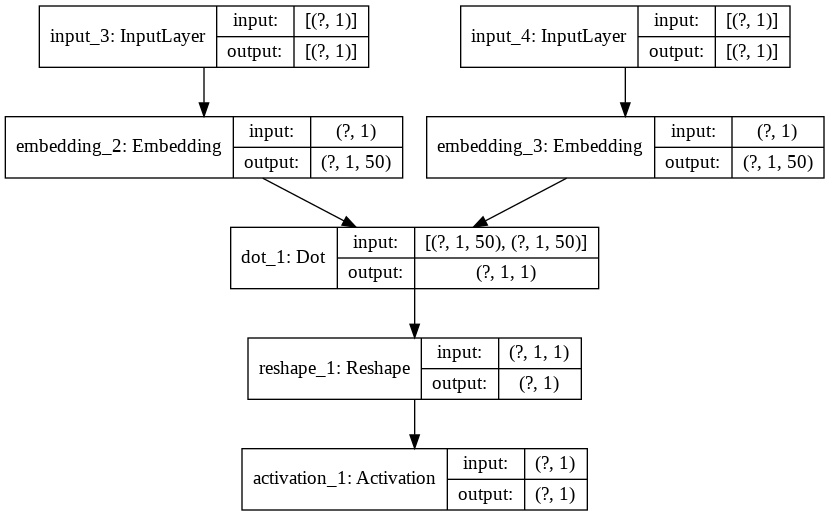

In [43]:
model = word2vec()
model.summary()
plot_model(model, show_shapes=True, show_layer_names=True)

In [46]:
for epoch in range(1,11):
  loss = 0
  for _, elem in enumerate(skip_grams):
    first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
    second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
    labels = np.array(elem[1], dtype='int32')
    X = [first_elem, second_elem]
    Y = labels
    loss += model.train_on_batch(X,Y)

  print('Epoch :', epoch,'Loss : ',loss)

Epoch : 1 Loss :  745.7215063497424
Epoch : 2 Loss :  652.872848033905
Epoch : 3 Loss :  611.1454066112638
Epoch : 4 Loss :  588.6895924210548
Epoch : 5 Loss :  574.0155674368143
Epoch : 6 Loss :  561.6093775965273
Epoch : 7 Loss :  548.850764811039
Epoch : 8 Loss :  534.6354647055268
Epoch : 9 Loss :  518.3749739862978
Epoch : 10 Loss :  500.0026018861681


In [51]:
import gensim

f = open('skipgram.txt','w')
f.write('{} {}\n'.format(vocab_size-1,embed_size))
vectors = model.get_weights()[0]
for word, i in tokenizer.word_index.items():
  f.write('{} {}\n'.format(word,' '.join(map(str, list(vectors[i, :])))))
f.close()

skipgram = gensim.models.KeyedVectors.load_word2vec_format('skipgram.txt', binary=False)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [52]:
skipgram.most_similar(positive=['soldier'])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('traps', 0.8822354078292847),
 ('ammunitions', 0.8147304058074951),
 ('villages', 0.7805995941162109),
 ('fascism', 0.7576587200164795),
 ('shostakovich', 0.7569740414619446),
 ('symphony', 0.755551278591156),
 ('indiscriminately', 0.7484070062637329),
 ('retalliates', 0.7474194765090942),
 ('evaluations', 0.7431292533874512),
 ('hurts', 0.7301101088523865)]

In [53]:
skipgram.most_similar(positive=['world'])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('moslems', 0.8248703479766846),
 ('wedding', 0.8188244104385376),
 ('pilot', 0.8125621676445007),
 ('subordinate', 0.812080979347229),
 ('splinter', 0.8111264109611511),
 ('trickier', 0.8086790442466736),
 ('irrational', 0.8079152703285217),
 ('towns', 0.8051877021789551),
 ('empowered', 0.8048665523529053),
 ('accompanied', 0.8021798729896545)]

### CBOW


#### CBOW 전처리

In [66]:
def skipgram2cbow(skipgrams):
  cbows = []
  flag = 0
  for n in skip_grams:
    temp1 = []
    for t in n:
      if flag == 1:
        flag = 0
        temp1.append(t)
      else:
        flag = 1
        temp2 = []
        for x in t:
          temp2.append([x[1], x[0]])
        temp1.append(temp2)
    cbows.append(temp1)
  return cbows

In [67]:
cbows = skipgram2cbow(skipgram)

In [68]:
pairs, labels = cbows[0][0], cbows[0][1]
for i in range(5):
  print('{:s}({:d}), {:s}({:d}) -> {:d}'.format(
      idx2word[pairs[i][0]], pairs[i][0],
      idx2word[pairs[i][1]], pairs[i][1],
      labels[i]
  ))

pucc(16701), seem(230) -> 0
n-t(33562), unfortunate(6417) -> 0
mrlk*.ck*v-c*rlk8.b_*.ck*+si(44848), disagree(1557) -> 0
=w(3195), israeli(789) -> 0
^zd03s(35156), incidences(10390) -> 0


In [69]:
print(len(cbows))
print(len(pairs))
print(len(labels))

2000
3220
3220


#### CBOW 모델 구성

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1, 50)        2276400     input_5[0][0]                    
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 1, 50)        2276400     input_6[0][0]                    
_______________________________________________________________________________________

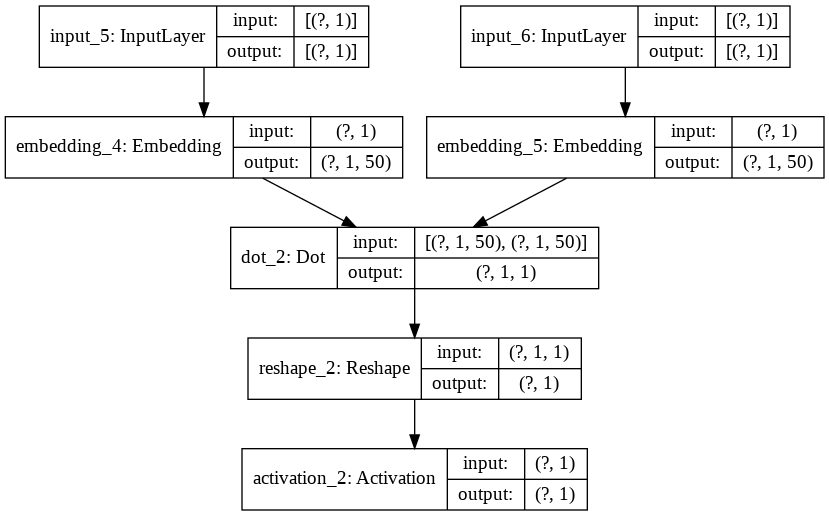

In [70]:
model = word2vec()
model.summary()
plot_model(model, show_shapes=True, show_layer_names=True)

In [72]:
for epoch in range(1,11):
  loss = 0
  for _, elem in enumerate(cbows):
    first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
    second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
    labels = np.array(elem[1], dtype='int32')
    X = [first_elem, second_elem]
    Y = labels
    loss += model.train_on_batch(X,Y)

  print('Epoch :', epoch,'Loss : ',loss)

Epoch : 1 Loss :  1065.0871670991182
Epoch : 2 Loss :  745.9228135868907
Epoch : 3 Loss :  652.8198079690337
Epoch : 4 Loss :  610.7587612643838
Epoch : 5 Loss :  587.8812460005283
Epoch : 6 Loss :  572.8719472885132
Epoch : 7 Loss :  560.2907562032342
Epoch : 8 Loss :  547.4253344871104
Epoch : 9 Loss :  533.1061880104244
Epoch : 10 Loss :  516.7705703675747


In [73]:
import gensim

f = open('cbow.txt','w')
f.write('{} {}\n'.format(vocab_size-1,embed_size))
vectors = model.get_weights()[0]
for word, i in tokenizer.word_index.items():
  f.write('{} {}\n'.format(word,' '.join(map(str, list(vectors[i, :])))))
f.close()

cbow = gensim.models.KeyedVectors.load_word2vec_format('cbow.txt', binary=False)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [74]:
cbow.most_similar(positive=['soldier'])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('numberable', 0.9513625502586365),
 ('appoximately', 0.9487676620483398),
 ('authenticators', 0.9478874206542969),
 ('breasts', 0.9474793076515198),
 ('democrat-westernizers', 0.947185218334198),
 ('reenacted', 0.9470229744911194),
 ('annointed', 0.9457451701164246),
 ('invoke', 0.9439807534217834),
 ('plaintiff', 0.9438374638557434),
 ('interject', 0.9434980154037476)]

In [75]:
cbow.most_similar(positive=['soldier'])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('numberable', 0.9513625502586365),
 ('appoximately', 0.9487676620483398),
 ('authenticators', 0.9478874206542969),
 ('breasts', 0.9474793076515198),
 ('democrat-westernizers', 0.947185218334198),
 ('reenacted', 0.9470229744911194),
 ('annointed', 0.9457451701164246),
 ('invoke', 0.9439807534217834),
 ('plaintiff', 0.9438374638557434),
 ('interject', 0.9434980154037476)]